# Convolutional Conditional Neural Process (ConvCNP)

```{figure} ../images/computational_graph_ConvCNPs.svg
---
width: 300em
name: computational_graph_ConvCNPs
alt: Computational graph ConvCNP
---
Computational graph for Convolutional Conditional Neural Processes.
```

In this notebook we will show how to train a ConvCNP on samples from GPs and images using our framework, as well as how to make nice visualizations.
ConvCNPs are CNPFs that use use convolutions for the aggregator (computational graph in {numref}`computational_graph_ConvCNPs`).
We will follow quite closely the previous {doc}`CNP notebook <CNP>`, but will also run a larger model (on CelebA128) to test super resolution.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import logging
import os
import warnings

import matplotlib.pyplot as plt
import torch

os.chdir("../..")

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
logging.disable(logging.ERROR)

N_THREADS = 8
IS_FORCE_CPU = False  # Nota Bene : notebooks don't deallocate GPU memory

if IS_FORCE_CPU:
    os.environ["CUDA_VISIBLE_DEVICES"] = ""

torch.set_num_threads(N_THREADS)

## Initialization

Let's load all the data. For more details about the data and some samples, see the {doc}`data <Datasets>` notebook.
In addition, we'll use Celeba128 dataset.

In [2]:
from utils.ntbks_helpers import get_all_gp_datasets, get_img_datasets

# DATASETS
# gp
gp_datasets, gp_test_datasets, gp_valid_datasets = get_all_gp_datasets()
# image
img_datasets, img_test_datasets = get_img_datasets(["celeba32", "mnist", "zsmms"])

imgXL_datasets, imgXL_test_datasets = get_img_datasets(["celeba128"])

Now let's define the context target splitters, which given a data point will return the context set and target set by selecting randomly selecting some points and preprocessing them so that the features are in $[-1,1]$. 
We use the same as in {doc}`CNP notebook <CNP>`, namely all target points and uniformly sampling in $[0,50]$ and $[0,n\_pixels * 0.3]$ for 1D and 2D respectively.

The only difference with the previous notebooks is that for the "on the grid" case (images) we will return the mask (instead of preprocessing the context sets) which makes facilitates the implementation by running a standard CNN. As we do not preprocess the pixels to $[-1,1]$, we do not have to deal with ZSMM differently despite the fact that the size of training and testing images is different.

In [3]:
from npf.utils.datasplit import (
    CntxtTrgtGetter,
    GetRandomIndcs,
    GridCntxtTrgtGetter,
    RandomMasker,
    get_all_indcs,
    no_masker,
)
from utils.data import cntxt_trgt_collate, get_test_upscale_factor

# CONTEXT TARGET SPLIT
get_cntxt_trgt_1d = cntxt_trgt_collate(
    CntxtTrgtGetter(
        contexts_getter=GetRandomIndcs(a=0.0, b=50), targets_getter=get_all_indcs,
    )
)
get_cntxt_trgt_2d = cntxt_trgt_collate(
    GridCntxtTrgtGetter(
        context_masker=RandomMasker(a=0.0, b=0.3), target_masker=no_masker,
    ),
    is_return_masks=True,  # will be using grid conv CNP => can work directly with mask
)

Let's now define the models. For all the models we: (i) do not encode context points independently of each other; (ii) use 4 hidden layer MLP that predicts the distribution of the target value given the context representation at target position;  [^decoder] (iii) always use hidden representations of size (or number of channels) 128 dimensions.
The implementation to get a target dependent representation of the context set differs slightly depending on the dataset:

* off the grid (GP datasets):
    1. Set convolution with normalized Gaussian RBF kernel to get a functional representation of the context set, and concatenate the density channel.
    2. Uniformly discretize (64 points per unit) the output function to enable the use of standard CNNs.
    3. 10 layer ResNet to process the functional representation.
    4. Set Convolution with normalized Gaussian RBF kernel and query at each target feature.


* on the grid  (MNIST, CelebA32): 
    1. Apply the mask, a convolutional layer with positive weights, concatenate the mask.
    2. 10 layer ResNet to process the functional representation.


* large model (CelebA128): Same as "on the grid" but with a 24 layer ResNet.

* full translation equivariance (ZSMM): Same as "on the grid" but with circular padding to ensure translation equivariance of the CNN (see appendix D.6 {cite}`gordon2019convolutional`)


[^decoder]: Note that the MLP does not take as input the absolute value of the target feature to be translation equivariant.

In [4]:
from functools import partial

from npf import ConvCNP, GridConvCNP
from npf.architectures import CNN, MLP, ResConvBlock, SetConv, discard_ith_arg
from npf.utils.helpers import CircularPad2d, make_abs_conv, make_padded_conv
from utils.helpers import count_parameters

R_DIM = 128
KWARGS = dict(
    r_dim=R_DIM,
    Decoder=discard_ith_arg(  # disregards the target features to be translation equivariant
        partial(MLP, n_hidden_layers=4, hidden_size=R_DIM), i=0
    ),
)


CNN_KWARGS = dict(
    ConvBlock=ResConvBlock,
    is_chan_last=True,  # all computations are done with channel last in our code
    n_conv_layers=2,  # layers per block
)


# off the grid
model_1d = partial(
    ConvCNP,
    x_dim=1,
    y_dim=1,
    Interpolator=SetConv,
    CNN=partial(
        CNN,
        Conv=torch.nn.Conv1d,
        Normalization=torch.nn.BatchNorm1d,
        n_blocks=5,
        kernel_size=19,
        **CNN_KWARGS,
    ),
    density_induced=64,  # density of discretization
    **KWARGS,
)


# on the grid
model_2d = partial(
    GridConvCNP,
    x_dim=1,  # for gridded conv it's the mask shape
    CNN=partial(
        CNN,
        Conv=torch.nn.Conv2d,
        Normalization=torch.nn.BatchNorm2d,
        n_blocks=5,
        kernel_size=9,
        **CNN_KWARGS,
    ),
    **KWARGS,
)

# full translation equivariance

Padder = CircularPad2d

model_2d_extrap = partial(
    GridConvCNP,
    x_dim=1,  # for gridded conv it's the mask shape
    CNN=partial(
        CNN,
        Normalization=partial(torch.nn.BatchNorm2d, eps=1e-2),  # was getting NaN
        Conv=make_padded_conv(torch.nn.Conv2d, Padder),
        n_blocks=5,
        kernel_size=9,
        **CNN_KWARGS,
    ),
    # make first layer also padded (all arguments are defaults besides `make_padded_conv` given `Padder`)
    Conv=lambda y_dim: make_padded_conv(make_abs_conv(torch.nn.Conv2d), Padder)(
        y_dim, y_dim, groups=y_dim, kernel_size=11, padding=11 // 2, bias=False,
    ),
    **KWARGS,
)

# large model
model_2d_XL = partial(
    GridConvCNP,
    x_dim=1,  # for gridded conv it's the mask shape
    CNN=partial(
        CNN,
        Conv=torch.nn.Conv2d,
        Normalization=torch.nn.BatchNorm2d,
        n_blocks=12,
        kernel_size=9,
        **CNN_KWARGS,
    ),
    **KWARGS,
)


n_params_1d = count_parameters(model_1d())
n_params_2d = count_parameters(model_2d(y_dim=3))
n_params_2d_XL = count_parameters(model_2d_XL(y_dim=3))

print(f"Number Parameters (1D): {n_params_1d:,d}")
print(f"Number Parameters (2D): {n_params_2d:,d}")
print(f"Number Parameters (2D XL): {n_params_2d_XL:,d}")

Number Parameters (1D): 276,612
Number Parameters (2D): 340,721
Number Parameters (2D XL): 722,417


For more details about all the possible parameters, refer to the docstrings of `ConvCNP` and `GridConvCNP` and the base class `NeuralProcessFamily`.

In [5]:
# ConvCNP Docstring

print(ConvCNP.__doc__)


    Convolutional conditional neural process [1].

    Parameters
    ----------
    x_dim : int
        Dimension of features.

    y_dim : int
        Dimension of y values.

    density_induced : int, optional
        Density of induced-inputs to use. The induced-inputs will be regularly sampled.

    Interpolator : callable or str, optional
        Callable to use to compute cntxt / trgt to and from the induced points.  {(x^k, y^k)}, {x^q} -> {y^q}. 
        It should be constructed via `Interpolator(x_dim, in_dim, out_dim)`. Example:
            - `SetConv` : uses a set convolution as in the paper.
            - `"TransformerAttender"` : uses a cross attention layer.

    CNN : nn.Module, optional
        Convolutional model to use between induced points. It should be constructed via 
        `CNN(r_dim)`. Important : the channel needs to be last dimension of input. Example:
            - `partial(CNN,ConvBlock=ResConvBlock,Conv=nn.Conv2d,is_chan_last=True` : uses a small 
      

In [6]:
# GridConvCNP Docstring

print(GridConvCNP.__doc__)


    Spacial case of Convolutional Conditional Neural Process [1] when the context, targets and
    induced points points are on a grid of the same size.

    Notes
    -----
    - Assumes that input, output and induced points are on the same grid. I.e. This cannot be used 
    for sub-pixel interpolation / super resolution. I.e. in the code *n_rep = *n_cntxt = *n_trgt =* grid_shape.
    The real number of ontext and target will be determined by the masks.
    - Assumes that Y_cntxt is the grid values (y_dim / channels on last dim),
    while X_cntxt and X_trgt are confidence masks of the shape of the grid rather
    than set of features.
    - As X_cntxt and X_trgt is a grid, each batch example could have a different number of
    contexts  and targets (i.e. different number of non zeros).
    - As we do not use a set convolution, the receptive field is easy to specify,
    making the model much more computationally efficient.

    Parameters
    ----------
    x_dim : int
        Dim

### Training

The main function for training is `train_models` which trains a dictionary of models on a dictionary of datasets and returns all the trained models.
See its docstring for possible parameters.



Computational Notes :
- The following will either train all the models (`is_retrain=True`) or load the pretrained models (`is_retrain=False`)
- it will use a (single) GPU if available
- decrease the batch size if you don't have enough memory
- 30 epochs should give you descent results for the GP datasets (instead of 100)
- if training celeba128 this takes a couple of days on a single GPU. You should get descent results using only 10 epochs instead of 50. If you don't want to train it, just comment out that block of code  when `is_retrain=True`.

In [7]:
import skorch
from npf import CNPFLoss
from utils.ntbks_helpers import add_y_dim
from utils.train import train_models

KWARGS = dict(
    is_retrain=False,  # whether to load precomputed model or retrain
    criterion=CNPFLoss,
    chckpnt_dirname="results/pretrained/",
    device=None,
    lr=1e-3,
    decay_lr=10,
    seed=123,
    batch_size=32,
)

# replace the zsmm model
models_2d = add_y_dim(
    {"ConvCNP": model_2d}, img_datasets
)  # y_dim (channels) depend on data
models_extrap = add_y_dim({"ConvCNP": model_2d_extrap}, img_datasets)
models_2d["zsmms"] = models_extrap["zsmms"]

# 1D
trainers_1d = train_models(
    gp_datasets,
    {"ConvCNP": model_1d},
    test_datasets=gp_test_datasets,
    iterator_train__collate_fn=get_cntxt_trgt_1d,
    iterator_valid__collate_fn=get_cntxt_trgt_1d,
    max_epochs=100,
    **KWARGS
)


# 2D
trainers_2d = train_models(
    img_datasets,
    models_2d,
    test_datasets=img_test_datasets,
    train_split=skorch.dataset.CVSplit(0.1),  # use 10% of training for valdiation
    iterator_train__collate_fn=get_cntxt_trgt_2d,
    iterator_valid__collate_fn=get_cntxt_trgt_2d,
    max_epochs=50,
    **KWARGS
)


# 2D XL
trainers_2dXL = train_models(
    imgXL_datasets,
    add_y_dim(
        {"ConvCNPXL": model_2d_XL}, imgXL_datasets
    ),  # y_dim (channels) depend on data
    # test_datasets=imgXL_test_datasets, # DEV
    train_split=skorch.dataset.CVSplit(0.1),  # use 10% of training for valdiation
    iterator_train__collate_fn=get_cntxt_trgt_2d,
    iterator_valid__collate_fn=get_cntxt_trgt_2d,
    max_epochs=50,
    **KWARGS
)


--- Loading RBF_Kernel/ConvCNP/run_0 ---

RBF_Kernel/ConvCNP/run_0 | best epoch: None | train loss: -226.017 | valid loss: None | test log likelihood: 175.1153

--- Loading Periodic_Kernel/ConvCNP/run_0 ---

Periodic_Kernel/ConvCNP/run_0 | best epoch: None | train loss: -265.034 | valid loss: None | test log likelihood: 192.9748

--- Loading Noisy_Matern_Kernel/ConvCNP/run_0 ---

Noisy_Matern_Kernel/ConvCNP/run_0 | best epoch: None | train loss: 63.0761 | valid loss: None | test log likelihood: -83.737

--- Loading Variable_Matern_Kernel/ConvCNP/run_0 ---

Variable_Matern_Kernel/ConvCNP/run_0 | best epoch: None | train loss: -258.4556 | valid loss: None | test log likelihood: -2737.2886

--- Loading All_Kernels/ConvCNP/run_0 ---

All_Kernels/ConvCNP/run_0 | best epoch: None | train loss: -92.6999 | valid loss: None | test log likelihood: 81.3551

--- Loading celeba32/ConvCNP/run_0 ---

celeba32/ConvCNP/run_0 | best epoch: 17 | train loss: -4850.5891 | valid loss: -4957.254 | test log 

### Plots

Let's visualize how well the model performs in different settings.

#### GPs Dataset

Let's define a plotting function that we will use in this section. We'll reuse the same function defined in {doc}`CNP notebook <CNP>`.

In [8]:
from utils.ntbks_helpers import PRETTY_RENAMER, plot_multi_posterior_samples_1d
from utils.visualize import giffify


def multi_posterior_gp_gif(filename, trainers, datasets, seed=123, **kwargs):
    giffify(
        save_filename=f"jupyter/gifs/{filename}.gif",
        gen_single_fig=plot_multi_posterior_samples_1d,  # core plotting
        sweep_parameter="n_cntxt",  # param over which to sweep
        sweep_values=[1, 2, 5, 7, 10, 15, 20, 30, 50, 100],
        fps=1.5,  # gif speed
        # PLOTTING KWARGS
        trainers=trainers,
        datasets=datasets,
        is_plot_generator=True,  # plot underlying GP
        is_plot_real=False,  # don't plot sampled / underlying function
        is_plot_std=True,  # plot the predictive std
        is_fill_generator_std=False,  # do not fill predictive of GP
        pretty_renamer=PRETTY_RENAMER,  # pretiffy names of modulte + data
        # Fix formatting for coherent GIF
        plot_config_kwargs=dict(
            set_kwargs=dict(ylim=[-3, 3]), rc={"legend.loc": "upper right"}
        ),
        seed=seed,
        **kwargs,
    )

##### Samples from a single GP

First, let us visualize the ConvCNP when it is trained on samples from a single GP.
We will directly evaluate in the "harder" extrapolation regime.

In [9]:
def filter_single_gp(d):
    return {k: v for k, v in d.items() if ("All" not in k) and ("Variable" not in k)}


multi_posterior_gp_gif(
    "ConvCNP_single_gp_extrap",
    trainers=filter_single_gp(trainers_1d),
    datasets=filter_single_gp(gp_test_datasets),
    left_extrap=-2,  # shift signal 2 to the right for extrapolation
    right_extrap=2,  # shift signal 2 to the right for extrapolation
)

```{figure} ../gifs/ConvCNP_single_gp_extrap.gif
---
width: 40em
name: ConvCNP_single_gp_extrap
---

Posterior predictive of ConvCNPs (Blue line with shaded area for $\mu \pm \sigma$) and the oracle GP (Green line with dashes for $\mu \pm \sigma$) when conditioned on contexts points (Black) from an underlying function sampled from a GP. Each row corresponds to a different kernel and ConvCNP trained on samples for the corresponding GP. The interpolation and extrapolation regime is delimited delimited by red dashes.
```


{numref}`ConvCNP_single_gp_extrap` shows that ConvCNP performs very well. Like AttnCNP ({numref}`AttnCNP_single_gp`) it does not suffer from underfitting, but it has the following advantages compared to AttnCNP:
1. It can extrapolate outside of the training range due to its translation equivariance. Note that there is no free lunch, this only happens because the underlying stochastic process is stationary.
2. It is quite smooth and does not have any "kinks".
3. It perform quite well on the periodic kernel. Note that it does not recover the underlying GP, for example it has a bounded receptive field and as a result can only model local periodicity.

To better showcase the latter issue, let's consider a much larger target interval ($[-2,14]$ instead of $[0,4]$) for the periodic kernel.

In [10]:
def filter_periodic(d):
    return {k: v for k, v in d.items() if ("Periodic" in k)}


multi_posterior_gp_gif(
    "ConvCNP_periodic_large_extrap",
    trainers=filter_periodic(trainers_1d),
    datasets=filter_periodic(gp_test_datasets),
    right_extrap=12,  # makes the target interval 4x larger
)

```{figure} ../gifs/ConvCNP_periodic_large_extrap.gif
---
width: 40em
name: ConvCNP_periodic_large_extrap
alt: ConvCNP on single images
---

Same as the 2nd row (Periodic Kernel) of {numref}`ConvCNP_single_gp_extrap` but with a much larger target interval ($[-2,14]$ instead of $[0,4]$).
```

{numref}`ConvCNP_periodic_large_extrap` shows that ConvCNP can only model local periodicity, which depends on the receptive field of the CNN.

In [11]:
###### ADDITIONAL 1D PLOTS ######

### Interp ###
multi_posterior_gp_gif(
    "ConvCNP_single_gp",
    trainers=filter_single_gp(trainers_1d),
    datasets=filter_single_gp(gp_test_datasets),
)

### Varying hyperparam ###
def filter_hyp_gp(d):
    return {k: v for k, v in d.items() if ("Variable" in k)}


multi_posterior_gp_gif(
    "ConvCNP_vary_gp",
    trainers=filter_hyp_gp(trainers_1d),
    datasets=filter_hyp_gp(gp_test_datasets),
    model_labels=dict(main="Model", generator="Fitted GP"),
)

### All kernels ###
# data with varying kernels simply merged single kernels
single_gp_datasets = filter_single_gp(gp_test_datasets)

# use same trainer for all, but have to change their name to be the same as datasets
base_trainer_name = "All_Kernels/ConvCNP/run_0"
trainer = trainers_1d[base_trainer_name]
replicated_trainers = {}
for name in single_gp_datasets.keys():
    replicated_trainers[base_trainer_name.replace("All_Kernels", name)] = trainer

multi_posterior_gp_gif(
    "ConvCNP_kernel_gp",
    trainers=replicated_trainers,
    datasets=single_gp_datasets
)

### Sampling ###
def filter_rbf(d):
    return {k: v for k, v in d.items() if ("RBF" in k)}


fig = plot_multi_posterior_samples_1d(
    trainers=filter_rbf(trainers_1d),
    datasets=filter_rbf(gp_test_datasets),
    n_cntxt=10,
    n_samples=3,
    left_extrap=-2,
    right_extrap=2
)
fig.savefig(f"jupyter/images/ConvCNP_rbf_samples.png", bbox_inches="tight")

#### Image Dataset

##### Conditional Posterior Predictive

Let us now look at images. We again will use the same plotting function defined in {doc}`CNP notebook <CNP>`.

In [12]:
from utils.ntbks_helpers import plot_multi_posterior_samples_imgs
from utils.visualize import giffify


def multi_posterior_imgs_gif(
    filename, trainers, datasets, seed=123, n_plots=3, **kwargs
):
    giffify(
        save_filename=f"jupyter/gifs/{filename}.gif",
        gen_single_fig=plot_multi_posterior_samples_imgs,  # core plotting
        sweep_parameter="n_cntxt",  # param over which to sweep
        sweep_values=[
            0,  
            0.005,
            0.01,
            0.02,
            0.05,
            0.1,
            0.15,
            0.2,
            0.3,
            0.5,
            "hhalf",  # horizontal half of the image
            "vhalf",  # vertival half of the image
        ],
        fps=1.5,  # gif speed
        # PLOTTING KWARGS
        trainers=trainers,
        datasets=datasets,
        n_plots=n_plots,  # images per datasets
        is_plot_std=True,  # plot the predictive std
        pretty_renamer=PRETTY_RENAMER,  # pretiffy names of modulte + data
        plot_config_kwargs={"font_scale":0.7},
        # Fix formatting for coherent GIF
        seed=seed,
        **kwargs,
    )

Let us visualize the CNP when it is trained on samples from different image datasets

In [13]:
multi_posterior_imgs_gif(
    "ConvCNP_img", trainers=trainers_2d, datasets=img_test_datasets,
)

```{figure} ../gifs/ConvCNP_img.gif
---
width: 40em
name: ConvCNP_img
alt: ConvCNP on CelebA, MNIST, ZSMM
---

Mean and std of the posterior predictive of an ConvCNP for CelebA $32\times32$, MNIST, and ZSMM for different context sets.
```

From {numref}`ConvCNP_img` we see that ConvCNP performs quite well on all datasets when the context set is large enough and uniformly sampled, even when extrapolation is needed (ZSMM). 
However, it does not perform great when the context set is very small or when it is structured, e.g., half images. Note that seems more of an issue for ConvCNP compared to AttnCNP ({numref}`AttnCNP_img`). We hypothesize that this happens because the effective receptive field of the former is too small (even though the theoretic size is larger than the image, it does not need such a large receptive field during training so effectively reduces it). For AttnCNP it is harder for the model to change the receptive field during training. This issue can be alleviated by reducing the size of the context set seen during training (to force the model to have a large receptive field).

Here are more samples, corresponding to specific percentiles of the test log loss.

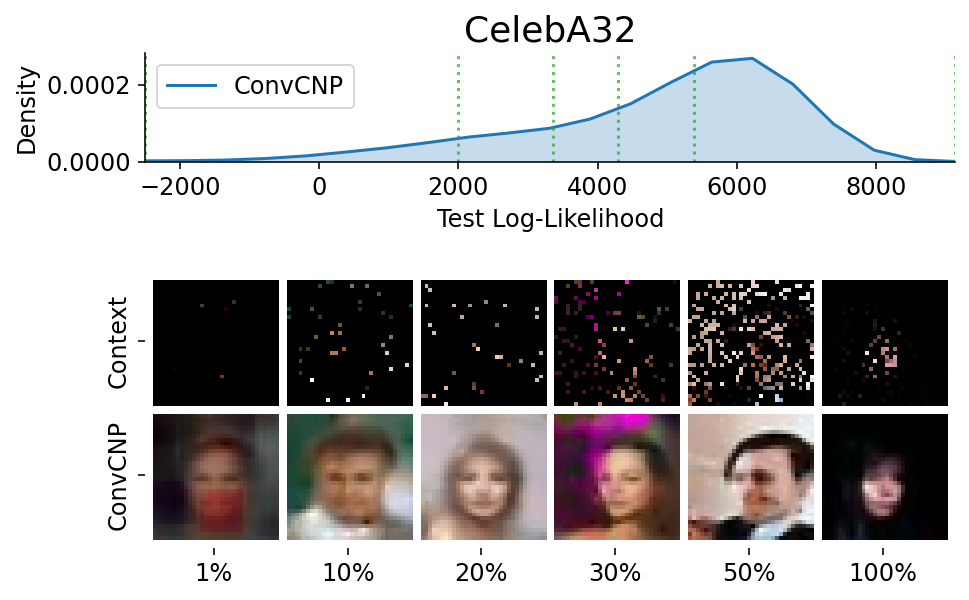

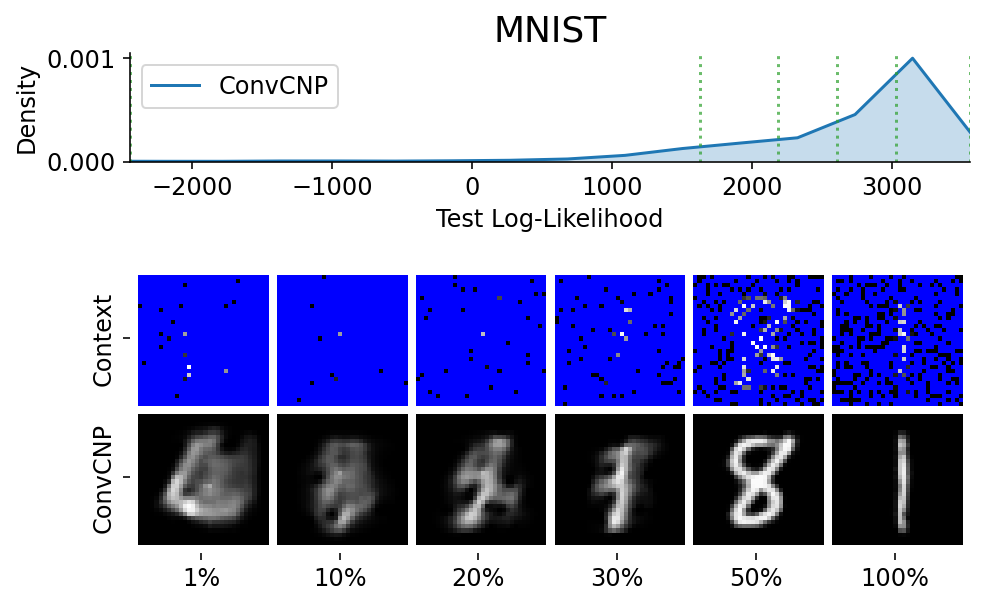

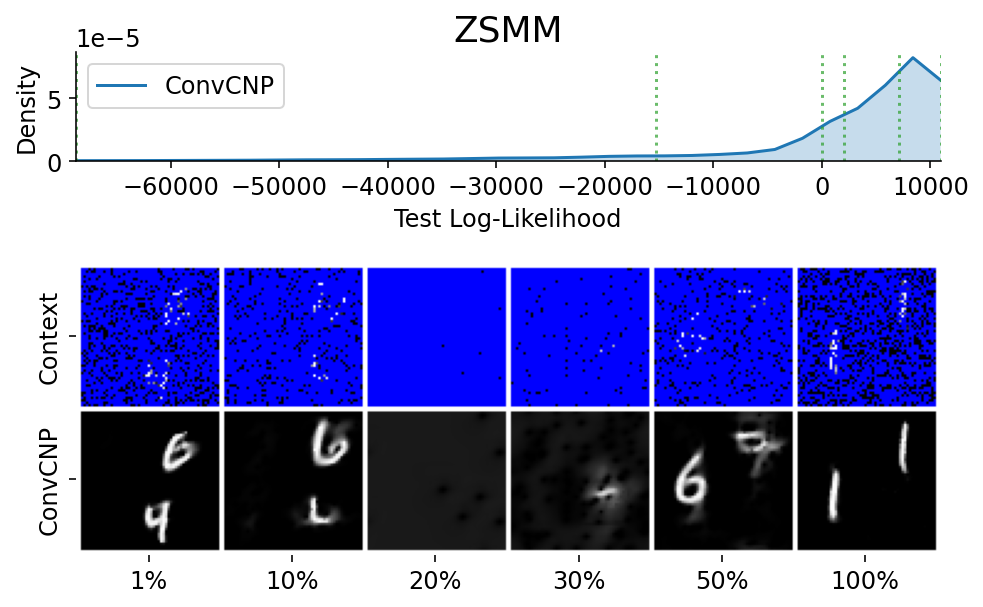

In [14]:
from utils.ntbks_helpers import PRETTY_RENAMER
from utils.visualize import plot_qualitative_with_kde

n_trainers = len(trainers_2d)
for i, (k, trainer) in enumerate(trainers_2d.items()):
    data_name = k.split("/")[0]
    model_name = k.split("/")[1]
    dataset = img_test_datasets[data_name]

    plot_qualitative_with_kde(
        [PRETTY_RENAMER[model_name], trainer],
        dataset,
        figsize=(7, 5),
        percentiles=[1, 10, 20, 30, 50, 100],
        height_ratios=[1, 5],
        is_smallest_xrange=True,
        h_pad=-1,
        title=PRETTY_RENAMER[data_name],
    )

Although the zero shot generalization when performing on ZSMM are encouraging, it still is a simple artificial dataset. 
Let us consider a more complex zero shot generalization, namely we will evaluate the large model trained on CelebA128 on a image with multiple faces of different scale and orientation.

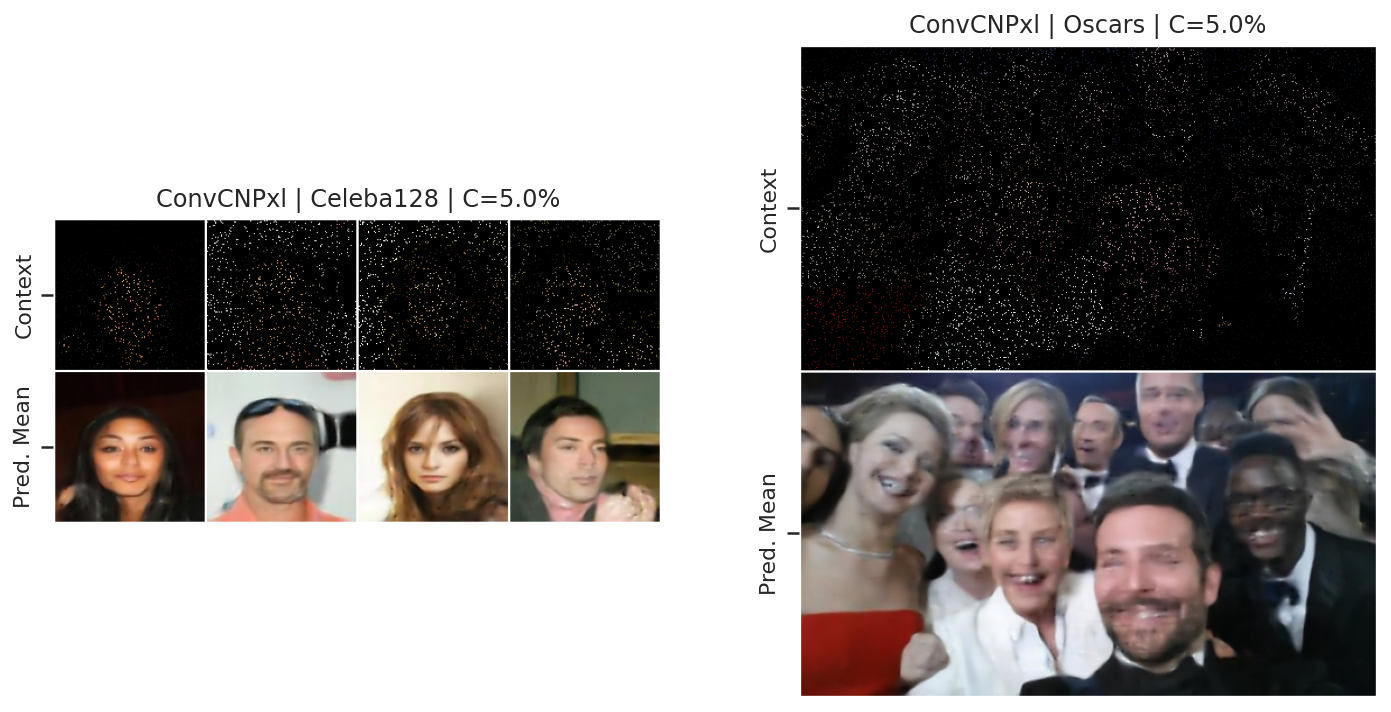

In [17]:
import matplotlib.image as mpimg

from utils.data.imgs import SingleImage

img = mpimg.imread("jupyter/images/ellen_selfie_oscars.jpeg")

oscar_datasets = SingleImage(img, resize=(288, 512))

k = "celeba128/ConvCNPXL/run_0"
# multi_posterior_imgs_gif(
#     "ConvCNP_img_zeroshot",
#     {k: trainers_2dXL[k], k.replace("celeba128", "oscars"): trainers_2dXL[k]},
#     {"oscars": oscar_datasets, **imgXL_test_datasets},
#     n_plots=2,
# )


fig = plot_multi_posterior_samples_imgs(
    {k: trainers_2dXL[k], k.replace("celeba128", "oscars"): trainers_2dXL[k]},
    {"oscars": oscar_datasets, **imgXL_test_datasets},
    0.05,
)
fig.savefig(f"jupyter/images/ConvCNP_img_zeroshot.png", bbox_inches="tight", format="jpeg", quality=80)

We see that the model is able to reasonably well generalize to real world data in a zero shot fashion.

##### Increasing Resolution

Although the previous results look nice the usecases are not obvious as it is not very common to have missing pixels.
One possible application, is increasing the resolution of an image. 
For the "off the grid" implementation this can be done by setting the target set features between context pixels ({cite}`kim2019attentive`).
For the current "on the grid" implementation, this can also be achieved by uniformly spacing out the context pixels on the desired grid size. [^supperres] 

Let us define the plotting function for increasing the resolution of an image.

[^supperres] The downside of the "on the grid" method is that it will work best if the desired object size are approximately the same size as those it was trained on.

In [18]:
from utils.ntbks_helpers import plot_multi_posterior_samples_imgs
from utils.visualize import giffify


def superres_gif(filename, trainers, datasets, seed=123, n_plots=3, **kwargs):
    giffify(
        save_filename=f"jupyter/gifs/{filename}.gif",
        gen_single_fig=plot_multi_posterior_samples_imgs,  # core plotting is same as before
        sweep_parameter="n_cntxt",  # param over which to sweep
        sweep_values=[1 / 16, 1 / 8, 1 / 4, 1 / 2],  # size of the input image
        fps=1.5,  # gif speed
        # PLOTTING KWARGS
        trainers=trainers,
        datasets=datasets,
        n_plots=n_plots,  # images per datasets
        is_plot_std=False,  # don't predictive std
        pretty_renamer=PRETTY_RENAMER,  # pretiffy names of modulte + data
        is_superresolution=True,  # decrease resolution of context image
        plot_config_kwargs={"font_scale":0.7},
        # Fix formatting for coherent GIF
        seed=seed,
        **kwargs,
    )

In [19]:
superres_gif("ConvCNP_superes", trainers=trainers_2dXL, datasets=imgXL_test_datasets)

```{figure} ../gifs/ConvCNP_superes.gif
---
width: 35em
name: ConvCNP_superes
alt: ConvCNP increasing resolution of images
---

Increasing the resolution of CelebA to $128 \times 128$ pixels by querying a ConvCNP a target positions between given pixels.
```

From {numref}`ConvCNP_superes` we see that NPFs can indeed be used to increase the resolution of an image, even though it was not trained to do so! Results can probably be improved by training NPFs in such setting. 

In [20]:
###### ADDITIONAL 2D PLOTS ######

### Superres png ###
fig = plot_multi_posterior_samples_imgs(
    trainers_2dXL,
    imgXL_test_datasets,
    1 / 8,
    is_superresolution=True,
    is_plot_std=False,
    figsize=(5,5),
)
fig.savefig(f"jupyter/images/ConvCNP_superes.png", bbox_inches="tight", quality=80)
plt.close(fig)

##### Issues With CNPFs

Although ConvCNPFs (and CNPFs) in general perform well, there are definitely some downside compared to other way of modeling stochastic processes.

First, CNPFs cannot be used to sample coherent functions, i.e. although the posterior predictive models well the underlying stochastic process it cannot be used for sampling. Indeed, the posterior predictive factorizes over the target set so there are no dependencies when sampling from the posterior predictive. The samples then look like the mean of the posterior predictive with with some Gaussian noise:

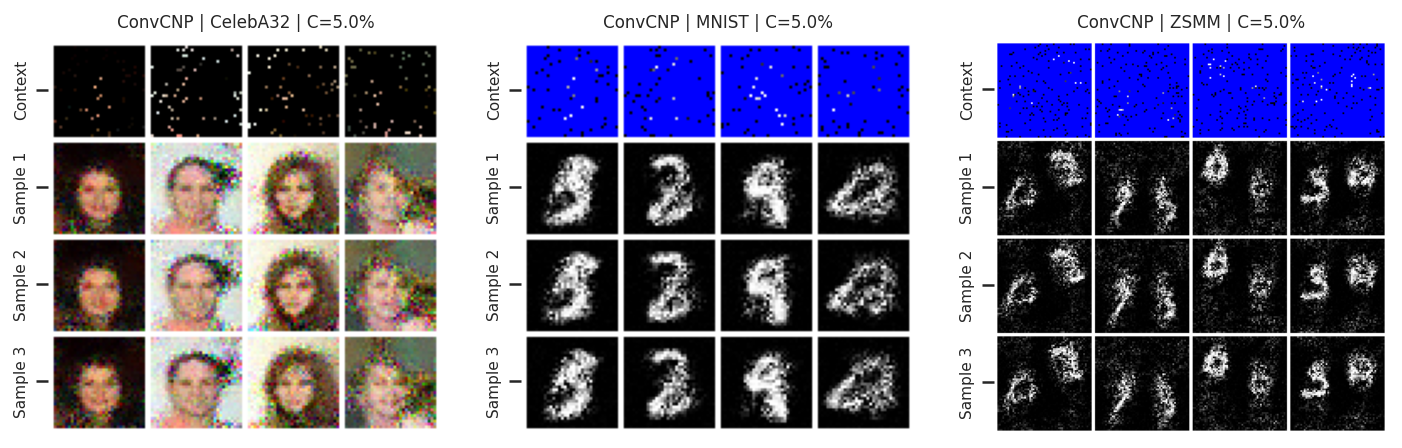

In [21]:
fig = plot_multi_posterior_samples_imgs(
    trainers_2d, img_test_datasets, 0.05, n_samples=3, is_plot_std=False, plot_config_kwargs={"font_scale":0.7},
)
fig.savefig(f"jupyter/images/ConvCNP_img_sampling.png", bbox_inches="tight", format="jpeg", quality=80)

An other issue with CNPFs is that the posterior predictive is always Gaussian. 
For example, let us plot the posterior predictive of a few pixels in MNIST.

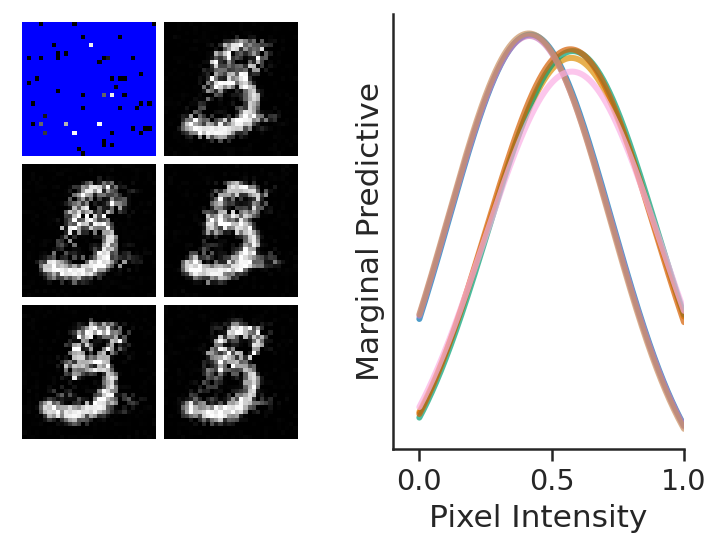

In [31]:
from utils.ntbks_helpers import select_labels
from utils.visualize import plot_config, plot_img_marginal_pred

with plot_config(font_scale=1.3, rc={"lines.linewidth": 3}):
    fig = plot_img_marginal_pred(
        trainers_2d["mnist/ConvCNP/run_0"].module_.cpu(),
        select_labels(img_test_datasets["mnist"], 3),  # Selecting a 3
        GridCntxtTrgtGetter(
            RandomMasker(a=0.05, b=0.05), target_masker=no_masker
        ),  # 5% context
        figsize=(6, 4),
        is_uniform_grid=True,  # on the grid model
        n_marginals=7,  # number of pixels posterior predictive
        n_samples=5,  # number of samples from the posterior pred
        n_columns=2,  # number of columns for the sampled
        seed=33,
    )
fig.savefig(f"jupyter/images/ConvCNP_marginal.png", bbox_inches="tight", format="jpeg", quality=90)

Note that it should be easy to replace the Gaussian with some other simple distribution such as a Laplace one, but it is not easily possible to make the posterior predictive highly complex and multi modal. A possible solution to solve these issues is to introduce latent variables, which we ill investigate in LNPFs notebooks.